I tried to look inside the image metadata.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import pydicom

from tqdm import tqdm_notebook

In [2]:
PATH = '../input/siim-acr-pneumothorax-segmentation-data/pneumothorax/'
field_list = ['PatientAge', 'PatientSex', 'ViewPosition']
attr_list = []

for fp in tqdm_notebook(glob.glob(os.path.join(PATH,'dicom-images-train/*/*/*.dcm'))):
    dataset = pydicom.dcmread(fp)
    obj = {'fp': fp}
    for f in field_list:
        obj[f] = getattr(dataset,f)    
    attr_list.append(obj)
    
frame = pd.DataFrame(attr_list)

How many values do these fields take?

In [3]:
frame.nunique()

PatientAge         93
PatientSex          2
ViewPosition        2
fp              10712
dtype: int64

Let's look at the age of the patient

In [4]:
frame['PatientAge'] = frame['PatientAge'].astype(np.int32)
frame['PatientAge'].sort_values(ascending=False).head()

4325    413
7488    148
6398     94
6465     90
6013     89
Name: PatientAge, dtype: int32

Wow! I see a 400 year old man, isn't  it?

In [5]:
frame['PatientAge'][frame['PatientAge']>90] = 90

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


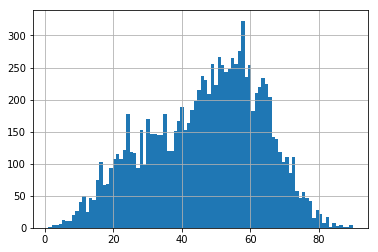

In [6]:
frame['PatientAge'].hist(bins=90)

In [7]:
frame['PatientSex'].value_counts()

M    5903
F    4809
Name: PatientSex, dtype: int64

In [8]:
frame['ViewPosition'].value_counts()

PA    6507
AP    4205
Name: ViewPosition, dtype: int64

In [9]:
pd.DataFrame(frame.groupby(['PatientSex','ViewPosition'])['PatientAge'].count())

PatientAge
PatientSex ViewPosition            
F          AP                  1710
           PA                  3099
M          AP                  2495
           PA                  3408

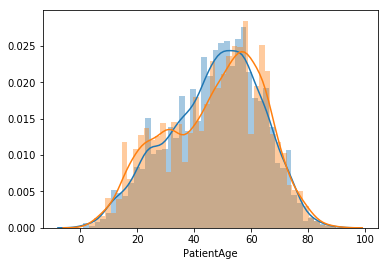

In [10]:
sns.distplot(frame['PatientAge'][frame['PatientSex']=='F'], bins=45)
sns.distplot(frame['PatientAge'][frame['PatientSex']=='M'], bins=45)

There are approximately same distiributions

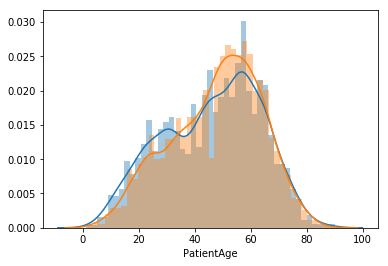

In [11]:
sns.distplot(frame['PatientAge'][frame['ViewPosition']=='AP'], bins=45)
sns.distplot(frame['PatientAge'][frame['ViewPosition']=='PA'], bins=45)

Time to discover mask image fraction

In [12]:
train_mask = pd.read_csv(os.path.join(PATH,'train-rle.csv'))

In [13]:
# This fucntion based on the same name function from kernel:
# https://www.kaggle.com/abhishek/image-mask-augmentations
def rle2mask(rle, width=1024, height=1024):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    if array.shape == (1,):
        return mask.reshape(width, height)
    starts = array[0::2]
    lengths = array[1::2]
    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 1
        current_position += lengths[index]
    return mask.reshape(width, height)

In [14]:
MASKS = train_mask[' EncodedPixels'].apply(rle2mask)
MASKS = np.array(MASKS)

In [15]:
fraction = [i.sum()/(1024**2) for i in tqdm_notebook(MASKS)]

Attention! Size of this data different from count of image

In [16]:
train_mask['fraction'] = fraction

In [17]:
mask_stats = train_mask.groupby('ImageId')['fraction'].agg(['sum','count'])

In [18]:
frame.shape, mask_stats.shape

((10712, 4), (10675, 2))

In [19]:
frame['ImageId'] = frame['fp'].apply(lambda x :os.path.split(x)[-1][:-4])

In [20]:
frame = frame.merge(mask_stats.reset_index())

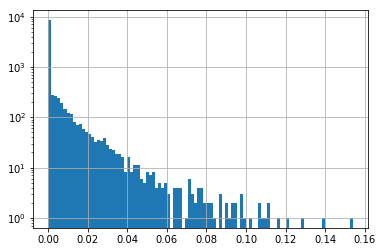

In [21]:
frame['sum'].hist(bins=100, log=True)

In [22]:
frame['log_sum'] = np.log(frame['sum']+0.01)

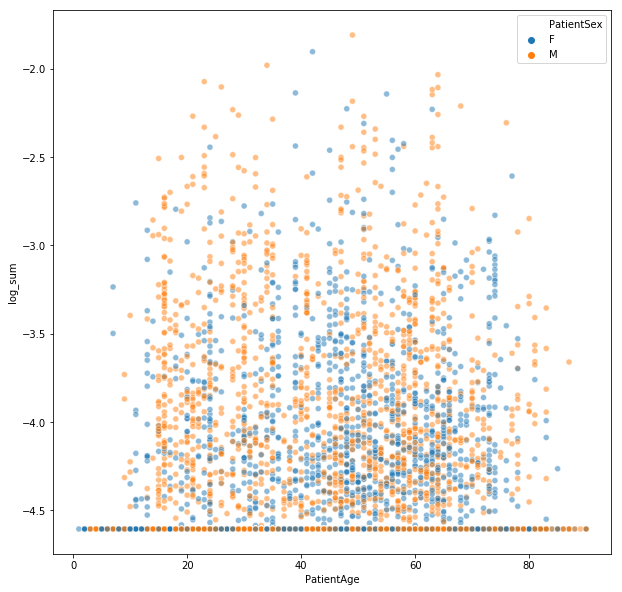

In [23]:
plt.figure(figsize=(10,10))
sns.scatterplot(y='log_sum', x='PatientAge', data=frame, hue='PatientSex', alpha=0.5)
plt.show()

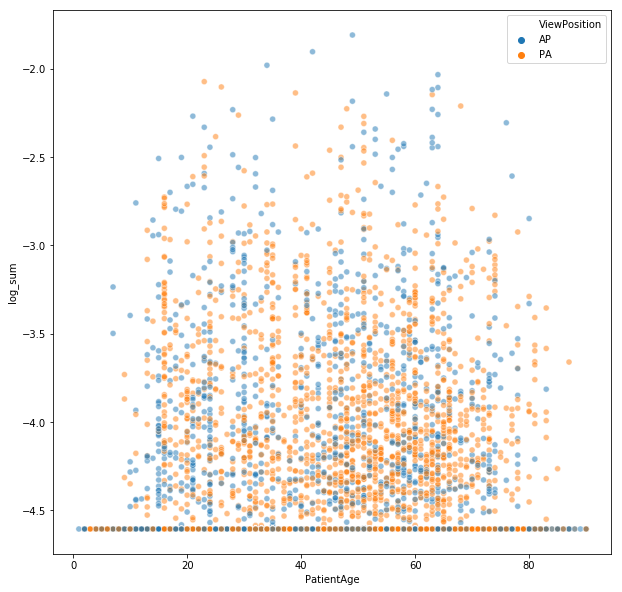

In [24]:
plt.figure(figsize=(10,10))
sns.scatterplot(y='log_sum', x='PatientAge', data=frame, hue='ViewPosition', alpha=0.5)
plt.show()

Ok! Can we say that the **youngest** and oldest patients do not have pneumothorax?

In [25]:
frame['count'].value_counts()

1     10051
2       447
3       112
4        40
5        18
6         3
8         2
7         1
10        1
Name: count, dtype: int64

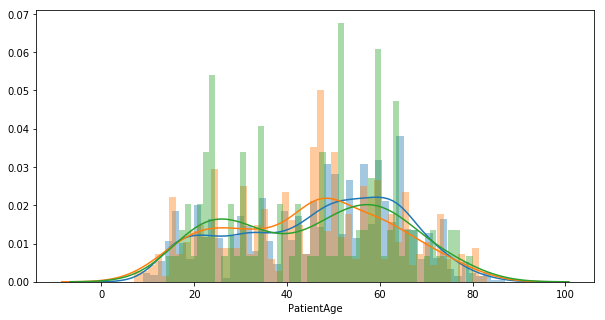

In [26]:
plt.figure(figsize=(10,5))
sns.distplot(frame['PatientAge'][(frame['count']==1) & (frame['sum']>0)], bins=50)
sns.distplot(frame['PatientAge'][frame['count']==2], bins=50)
sns.distplot(frame['PatientAge'][frame['count']==3], bins=50)
plt.show()

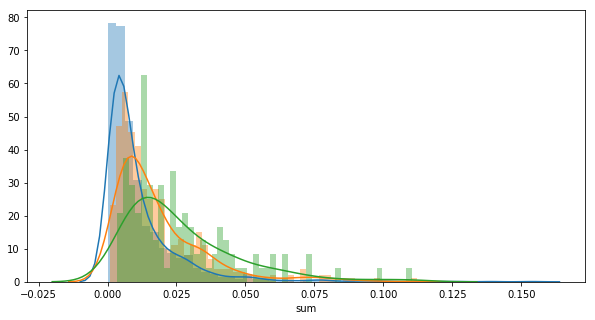

In [27]:
plt.figure(figsize=(10,5))
sns.distplot(frame['sum'][(frame['count']==1) & (frame['sum']>0)], bins=50, norm_hist=True)
sns.distplot(frame['sum'][frame['count']==2], bins=50, norm_hist=True)
sns.distplot(frame['sum'][frame['count']==3], bins=50, norm_hist=True)
plt.show()

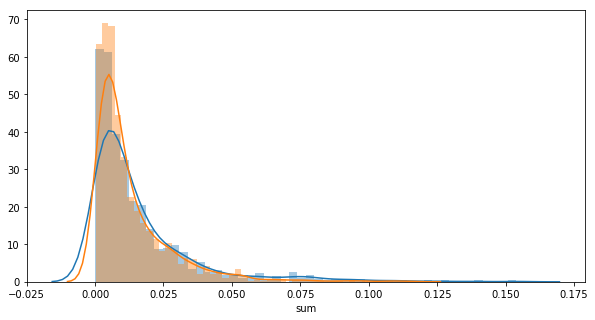

In [28]:
plt.figure(figsize=(10,5))
sns.distplot(frame['sum'][(frame['ViewPosition']=='AP') & (frame['sum']>0)], bins=50, norm_hist=True)
sns.distplot(frame['sum'][(frame['ViewPosition']=='PA') & (frame['sum']>0)], bins=50, norm_hist=True)
plt.show()

Work in progress...
Like, Share, Follow me...